# Heart Disease Prediction Using Logistic Regression

Here we try to use **Logistic Regression** from **scikit-learn** to predict **heart disease**.

Our goal is to have highest **F1** score.

Our steps:
1. Data Preprocessing
2. Data Splitting
3. Create Logistic Regression model
4. Search Optimal parameters using Grid or Random search technique and use **AUC** as a validation score
5. Find optimal threshold for binary decision
6. Score best model

## Introduction

World Health Organization has  estimated 12 million deaths occur worldwide, every year due to Heart diseases. Half the deaths in the United States and other developed countries are due to cardio vascular diseases. The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications. This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.


# Imports

In [61]:
# for vector computations and data processing
import pandas as pd
import numpy as np 

# for statistical work
import statsmodels.api as sm
import scipy.stats as st

# for plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import seaborn as sn

# for using ML models and their scoring
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, make_scorer, precision_score, recall_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Helper Functions

In [2]:
def hist_plot(dataframe, features, rows, cols):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=20, ax=ax, facecolor='midnightblue')
        ax.set_title(feature+" Distribution", color='DarkRed')

    fig.tight_layout()
    plt.show()

In [3]:
def pie_plot(series, figsize=(7, 7)):
    ax_ = plt.figure(figsize=figsize).add_subplot()
    ax_.pie(series.value_counts(), labels=series.value_counts().index)

In [4]:
def corr_plot(dataframe, figsize=(10, 10)):
    axes_ = plt.figure(figsize=figsize).add_subplot()
    corr = dataframe.corr()
    ax = sn.heatmap(
        corr,
        vmin=-1, vmax=1, center=0,
        cmap=sn.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

In [5]:
def barh_plot(series, figsize=(10, 10)):
    ax_ = plt.figure(figsize=figsize).add_subplot()
    ax_.barh(series.index, series.values)

In [6]:
def plot_roc_auc_curve(y_test, y_pred, clf, X_test):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.figure(figsize=[10,7])
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [7]:
def precision_recall_f1_curve_plot(y_test, y_pred_proba, figsize=(10, 10)):
    ax_ = plt.figure(figsize=figsize).add_subplot()
    df_ = pd.DataFrame(precision_recall_curve(y_test, y_pred_proba), index=['Precision', 'Recall', 'Threshold']).T
    df_['F1'] = 2*df_['Precision']*df_['Recall']/(df_['Precision'] + df_['Recall'])
    df_.plot(ax=ax_)
    optimal_threshold = df_[df_['F1'] == df_['F1'].max()]['Threshold'].iloc[0]
    return df_, optimal_threshold

In [8]:
def confusion_matrix_plot(y_test, y_pred, labels=(1, 0), figsize=(8, 5)):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    conf_matrix = pd.DataFrame(
        data=cm, columns=['Predicted:1', 'Predicted:0'], index=['Actual:1', 'Actual:0'])
    plt.figure(figsize=figsize)
    sn.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
    return cm

In [69]:
def show_scores(confusion_matrix):
    # get "default" confusion matrix values
    TP = confusion_matrix[0, 0]
    TN = confusion_matrix[1, 1]
    FP = confusion_matrix[1, 0]
    FN = confusion_matrix[0, 1]

    # calculate scores
    accuracy = (TP+TN)/float(TP+TN+FP+FN)
    precision = TP/float(TP+FN)
    recall = TP/float(TP+FP)
    f1 = 2*precision*recall/float(precision+recall)

    # print scores
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    
    return accuracy, precision, recall, f1

In [10]:
def binarize(probas, threshold):
    preds = (probas >= threshold).astype(np.int64)
    return preds

# Data Preparation

## Source:

The dataset is publically available on the Kaggle website, and it is from an ongoing ongoing cardiovascular study on residents of the town of Framingham, Massachusetts.  The classification goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD).The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.

## Read Data

In [11]:
heart_df=pd.read_csv("data/workshop_1/framingham.csv")

In [ ]:
# add new field called "female" which will be derived from male

#heart_df['female'] = heart_df['male']

In [12]:
heart_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Variables :

Each attribute is a potential risk factor. There are both **demographic**, **behavioural** and **medical** risk factors.

 - **Demographic:**
    - sex: male or female;(Nominal)

    -  age: age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)


 - **Behavioural**

    -  currentSmoker: whether or not the patient is a current smoker (Nominal)

    -  cigsPerDay: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarretts, even half a cigarette.)

 - **Medical( history):**

    -  BPMeds: whether or not the patient was on blood pressure medication (Nominal)

    -  prevalentStroke: whether or not the patient had previously had a stroke (Nominal)

    -  prevalentHyp: whether or not the patient was hypertensive (Nominal)

    -  diabetes: whether or not the patient had diabetes (Nominal)

 - **Medical(current):** 

    -  totChol: total cholesterol level (Continuous)

    -  sysBP: systolic blood pressure (Continuous)

    -  diaBP: diastolic blood pressure (Continuous)

    -  BMI: Body Mass Index (Continuous)

    -  heartRate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)

    -  glucose: glucose level (Continuous)


 - **Predict variable (desired target):**

    -  10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”)


## Missing Values Percentages

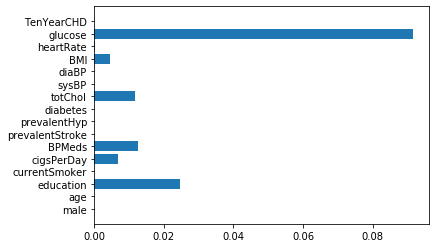

In [13]:
plt.barh(heart_df.isnull().sum().index, heart_df.isnull().sum()/heart_df.shape[0]);

In [14]:
na_percentage = ((heart_df.shape[0] - heart_df.dropna().shape[0])/heart_df.shape[0])*100.0

In [16]:
na_percentage

13.726415094339622

In [17]:
print(f'we will remove missing values since we have {np.around(na_percentage, decimals=2)} percent of rows in total with empty values')

we will remove missing values since we have 13.73 percent of rows in total with empty values


In [18]:
heart_df.shape

(4240, 16)

In [19]:
# remove all rows with na values

heart_df.dropna(axis=0, how='any', inplace=True)


In [20]:
heart_df.shape

(3658, 16)

**Removing rows with nan's is not a good approach! For better feature engineering there are many approaches to fill missing values if it's possible. Such process is called data [imputation](https://scikit-learn.org/stable/modules/impute.html) and is frequently done on missing values if the percentage of missing values are less than 5% (Can be more depending on your needs)**

# Exploratory Data Analysis

## Look At Features Distributions

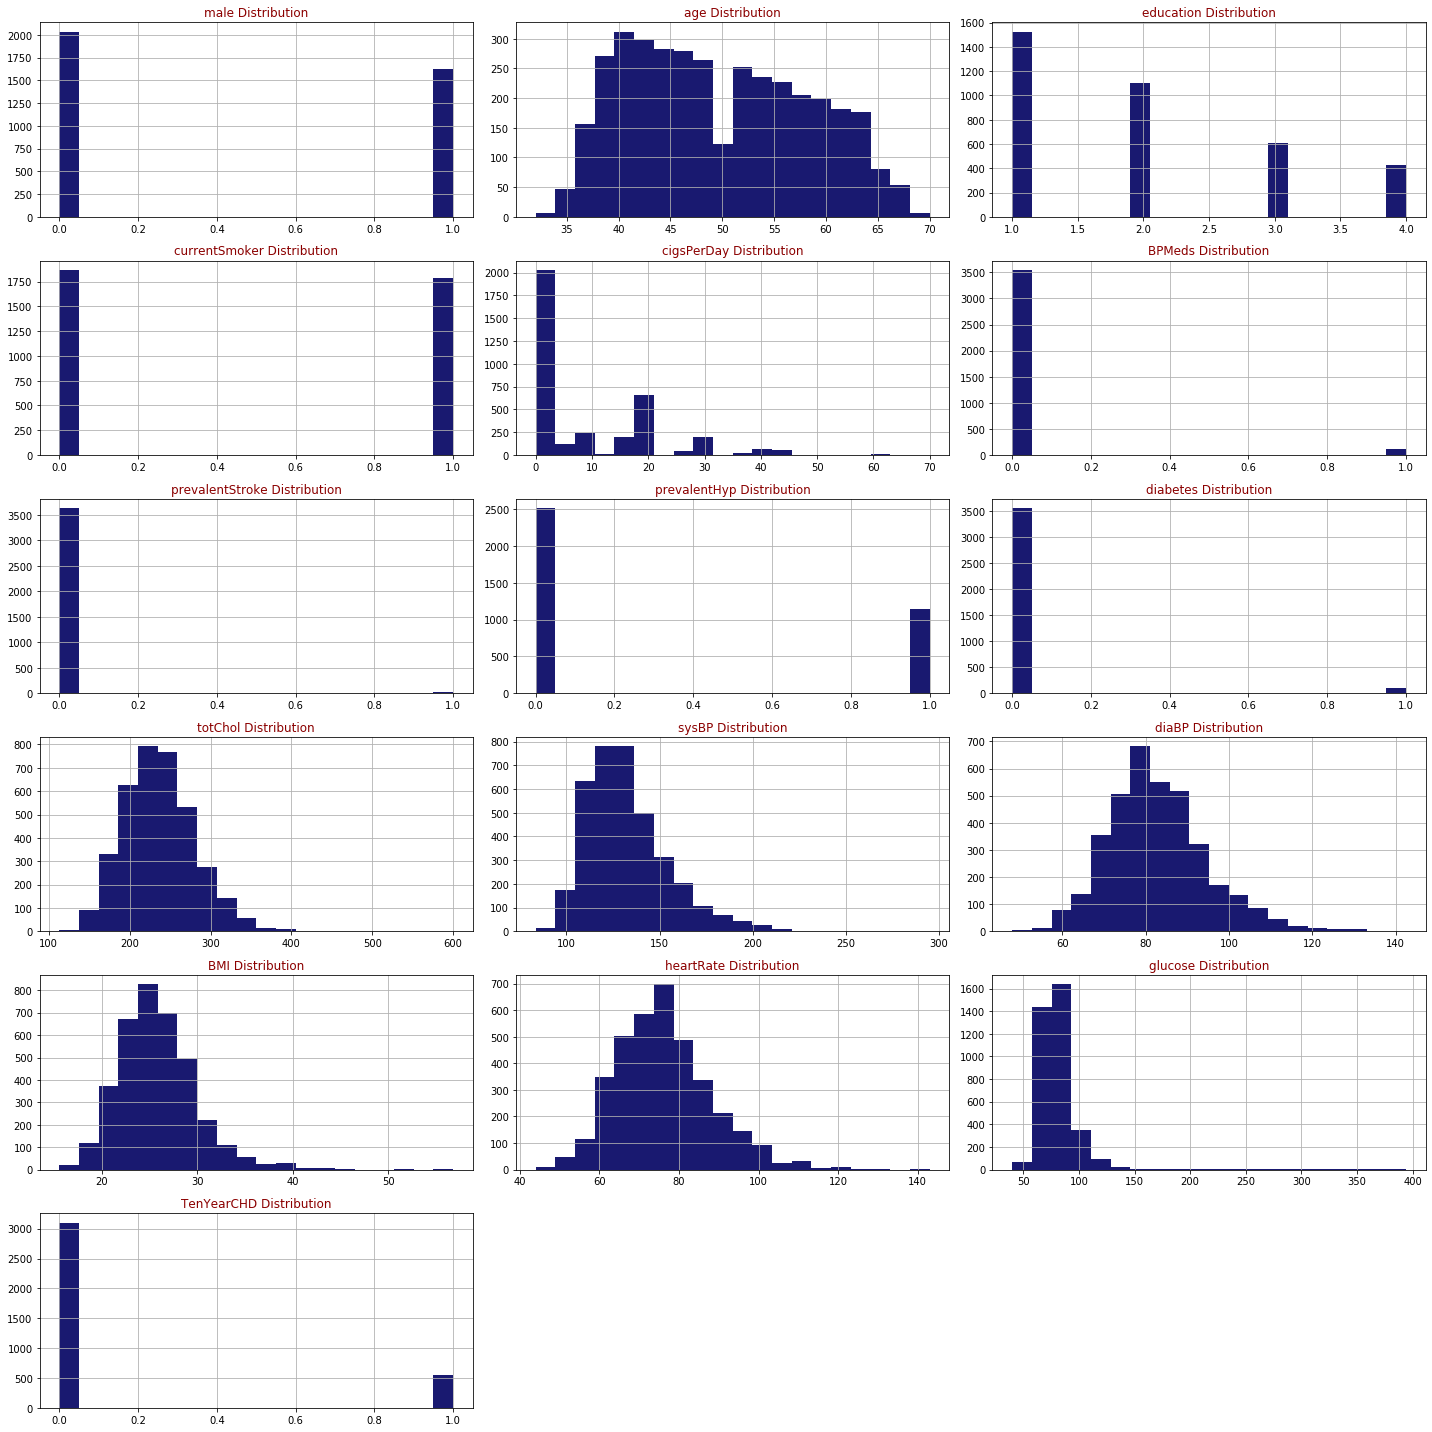

In [21]:
hist_plot(dataframe=heart_df, features=heart_df.columns, rows=6, cols=3)

## Look at main statistical properties

In [23]:
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
male,3658.0,0.443685,0.496886,0.00,0.00,0.00,1.0000,1.0
age,3658.0,49.551941,8.562029,32.00,42.00,49.00,56.0000,70.0
education,3658.0,1.980317,1.022656,1.00,1.00,2.00,3.0000,4.0
currentSmoker,3658.0,0.489065,0.499949,0.00,0.00,0.00,1.0000,1.0
cigsPerDay,3658.0,9.025424,11.921590,0.00,0.00,0.00,20.0000,70.0
BPMeds,3658.0,0.030344,0.171557,0.00,0.00,0.00,0.0000,1.0
prevalentStroke,3658.0,0.005741,0.075561,0.00,0.00,0.00,0.0000,1.0
prevalentHyp,3658.0,0.311646,0.463229,0.00,0.00,0.00,1.0000,1.0
diabetes,3658.0,0.027064,0.162292,0.00,0.00,0.00,0.0000,1.0
totChol,3658.0,236.847731,44.097681,113.00,206.00,234.00,263.0000,600.0


## Show Feature PairWise Scatter Plots

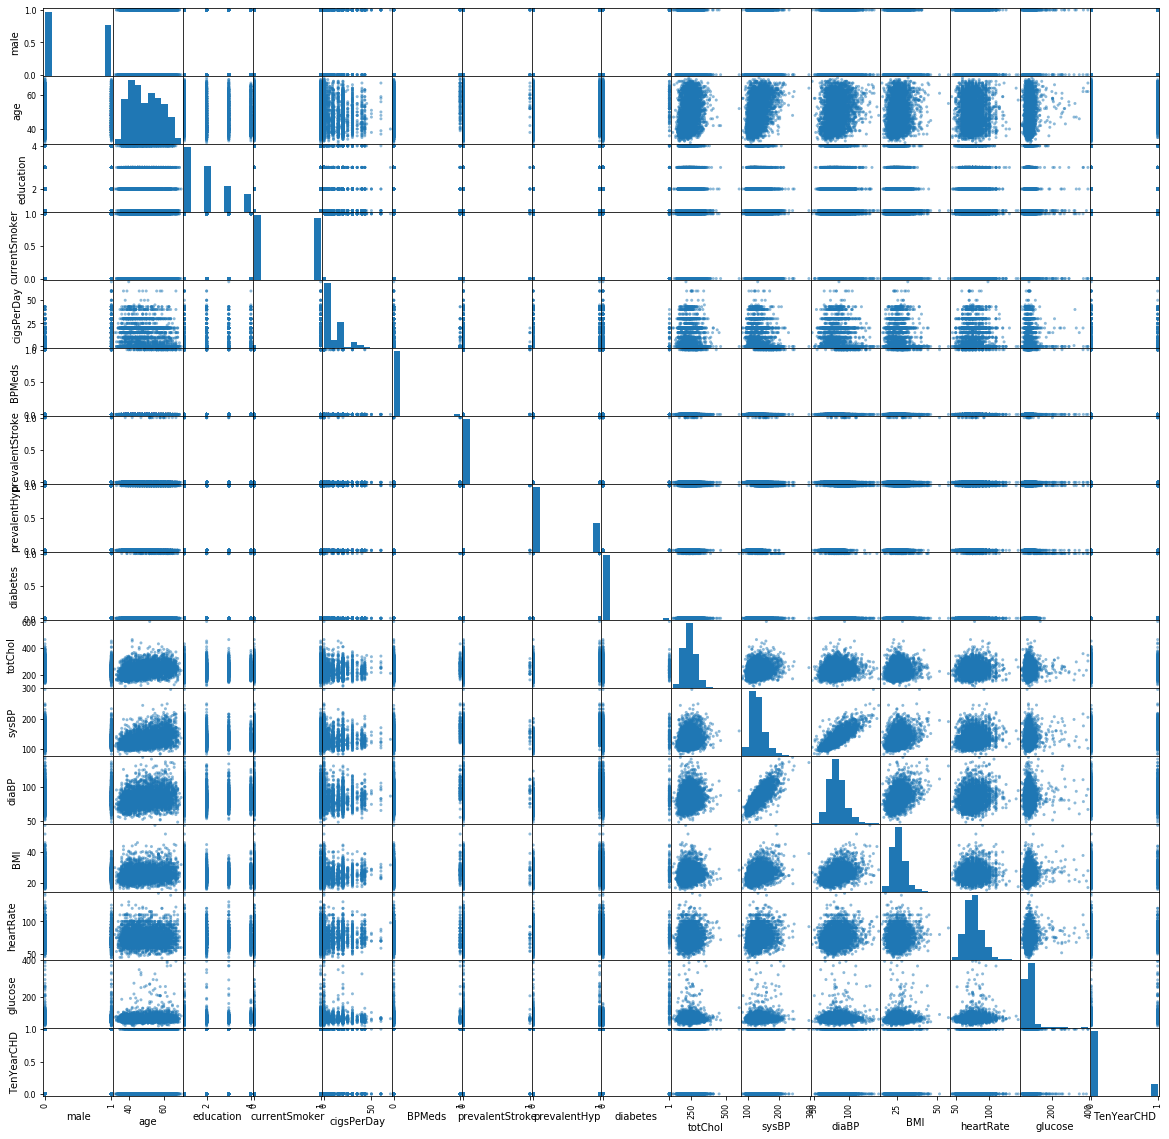

In [24]:
pd.plotting.scatter_matrix(heart_df, figsize=(20, 20));

## Show feature correlations

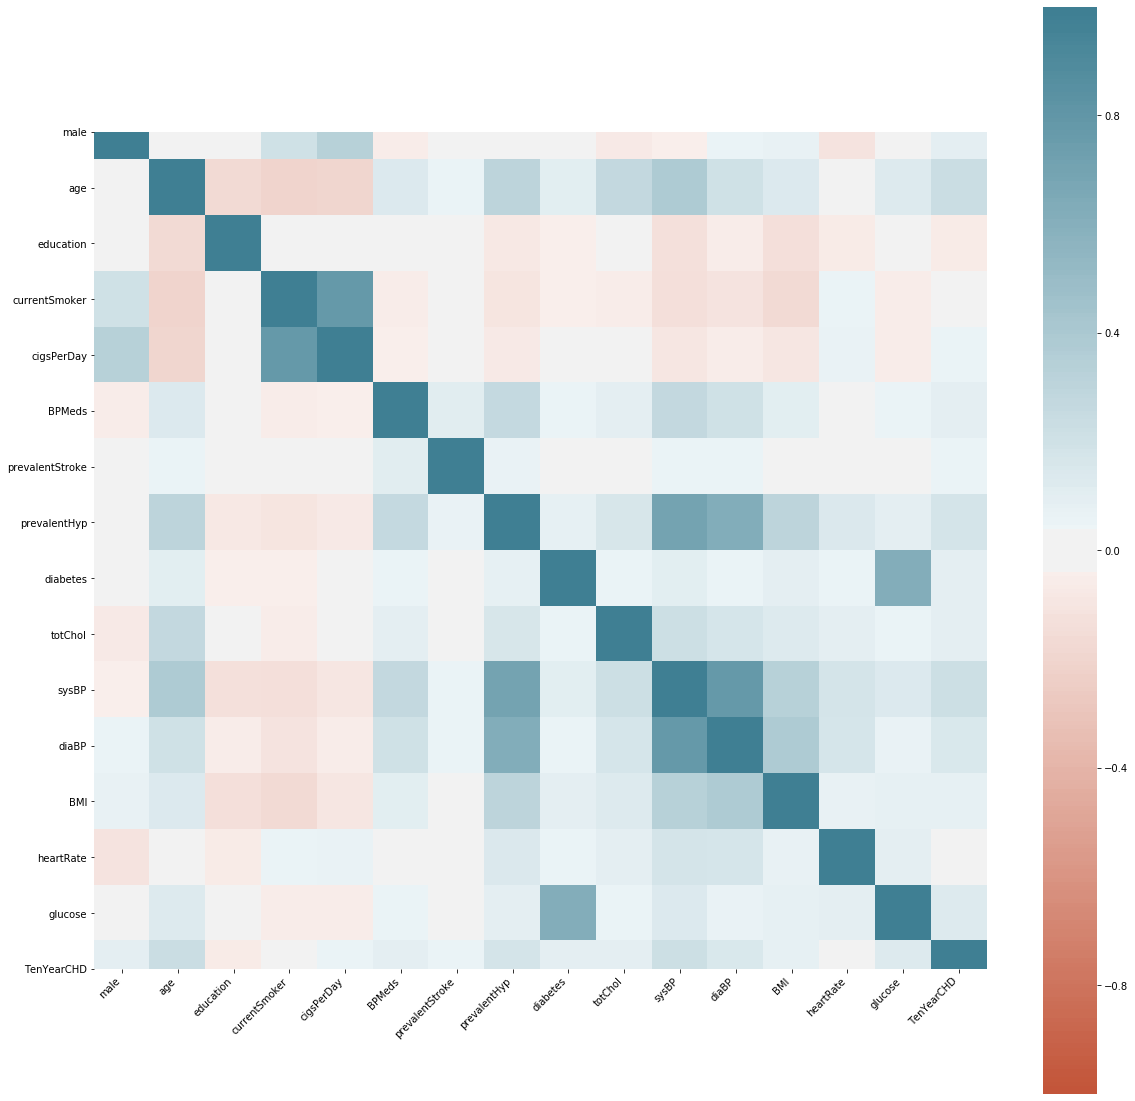

In [25]:
corr_plot(heart_df, figsize=(20,20))

## Show Features Correlations with Target sorted with absolute value

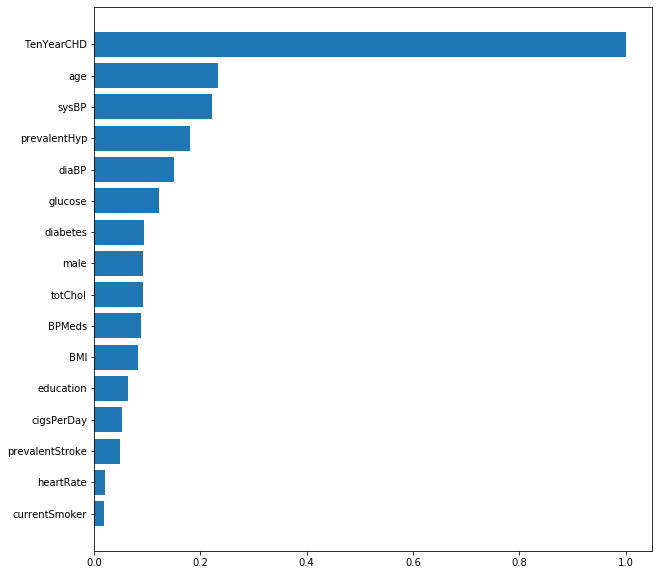

In [26]:
barh_plot(heart_df.corr()['TenYearCHD'].abs().sort_values(ascending=True))

In [27]:
heart_df.corr()['TenYearCHD'].abs().sort_values(ascending=True)

currentSmoker      0.019165
heartRate          0.020514
prevalentStroke    0.048366
cigsPerDay         0.052014
education          0.063279
BMI                0.082055
BPMeds             0.089152
totChol            0.091338
male               0.091688
diabetes           0.093431
glucose            0.121990
diaBP              0.150124
prevalentHyp       0.181387
sysBP              0.222821
age                0.233983
TenYearCHD         1.000000
Name: TenYearCHD, dtype: float64

## See target value distribution

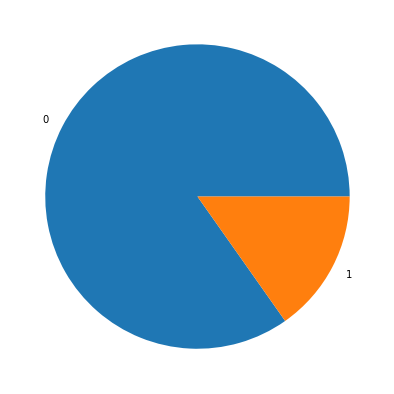

In [28]:
pie_plot(heart_df.TenYearCHD)

In [29]:
print(f'There are {(heart_df.TenYearCHD == 0).sum()} patents with no heart disease and {(heart_df.TenYearCHD == 1).sum()} patients with risk of heart disease.')

There are 3101 patents with no heart disease and 557 patients with risk of heart disease.


## Choose top high correlated features  (Optional)

- glucose            0.121990
- diaBP              0.150124
- prevalentHyp       0.181387
- sysBP              0.222821
- age                0.233983
- TenYearCHD         1.000000

In [30]:
 heart_df = heart_df[['glucose', 'diaBP', 'prevalentHyp', 'sysBP', 'age', 'TenYearCHD']]

In [32]:
heart_df.head()

,glucose,diaBP,prevalentHyp,sysBP,age,TenYearCHD
0,77.0,70.0,0,106.0,39,0
1,76.0,81.0,0,121.0,46,0
2,70.0,80.0,0,127.5,48,0
3,103.0,95.0,1,150.0,61,1
4,85.0,84.0,0,130.0,46,0


# Data Splitting

In [43]:
# Copy all features except target to X and target to Y
X = heart_df[["glucose","diaBP", "prevalentHyp","sysBP","age"]]
Y = heart_df['TenYearCHD']

In [50]:
X.shape, Y.shape

((3658, 5), (3658,))

Let's take 20% of samples for test

In [51]:
# Split data into train and test set with 20% of test samples, stratify with target and random state 5

x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=5, test_size=0.2)

In [53]:
x_train.shape

(2926, 5)

In [54]:
x_test.shape

(732, 5)

# Logistic Regression

Logistic regression is a type of regression analysis in statistics used for prediction of outcome of a categorical dependent variable from a set of predictor or independent variables. In logistic regression the dependent variable is always binary. Logistic regression is mainly used to for prediction and also calculating the probability of success. 

[Logistic Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [55]:
# create logistic regression model
model = LogisticRegression()

### HyperParameters of Logistic Regression

Subset of parameters for tuning

- penalty : str, ‘l1’, ‘l2’, ‘elasticnet’ or ‘none’, optional (default=’l2’)
- C : float, optional (default=1.0)
- class_weight : dict or ‘balanced’, optional (default=None)
- solver : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, optional (default=’liblinear’).
- max_iter : int, optional (default=100)

## RandomizedSearchCV

### Check Random Distribution for Regularization Parameter

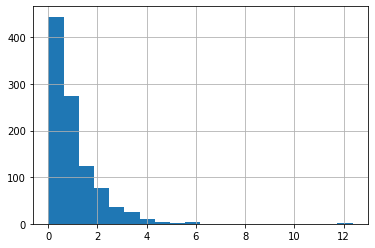

In [56]:
pd.Series(st.expon.rvs(size=1000)).hist(bins=20)

### Create Random Parameters

see parameters choosing for random search [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py)

In [57]:
# create random parameters for cross validated random search
parameters = {
    'penalty': ['l1', 'l2'],
    'C': st.expon.rvs(size=200),
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'saga'],
    'max_iter': np.random.rand(100)*200
}

### Create Random Seardh Object

See scoring parameters example [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)

In [64]:
RANDOM_STATE = 42
CV = 5
RANDOM_ITERS = 50
# Create scoring parameters for AUC, Recall and Precision
SCORING = {
    "AUC": "roc_auc",
    "Recall":make_scorer(recall_score),
    "Precision":make_scorer(precision_score)}

create [random search cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) object using:
- estimator: our initialized logistic regression model
- random_state: which we defined
- param_distributions: defined search parameters
- cv: cross validation splits number which we defined above
- scoring: prepared scoring parameters
- refit: "AUC" to get model with best AUC score
- verbose: True if want to see logs of model training
- n_jobs: -1 if want to train on all CPU resource (does faster)
- n_iter: number of iterations for choosing random models

In [65]:
# crete random search cross validation object here with paramaters defined above
random_model = RandomizedSearchCV(estimator=model,
                                  random_state=RANDOM_STATE,
                                  param_distributions=parameters,
                                  cv=CV,
                                  scoring=SCORING,
                                  refit='AUC',
                                  verbose=True,
                                  n_jobs=-1,
                                  n_iter=RANDOM_ITERS)

### Get Best Model

In [66]:
# fit model on training data

best_random_model = random_model.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 243 out of 250 | elapsed:    8.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    9.0s finished
/home/okroshiashvili/miniconda3/envs/maisai/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Show Cross Validation Results on all Searched Parameter Models

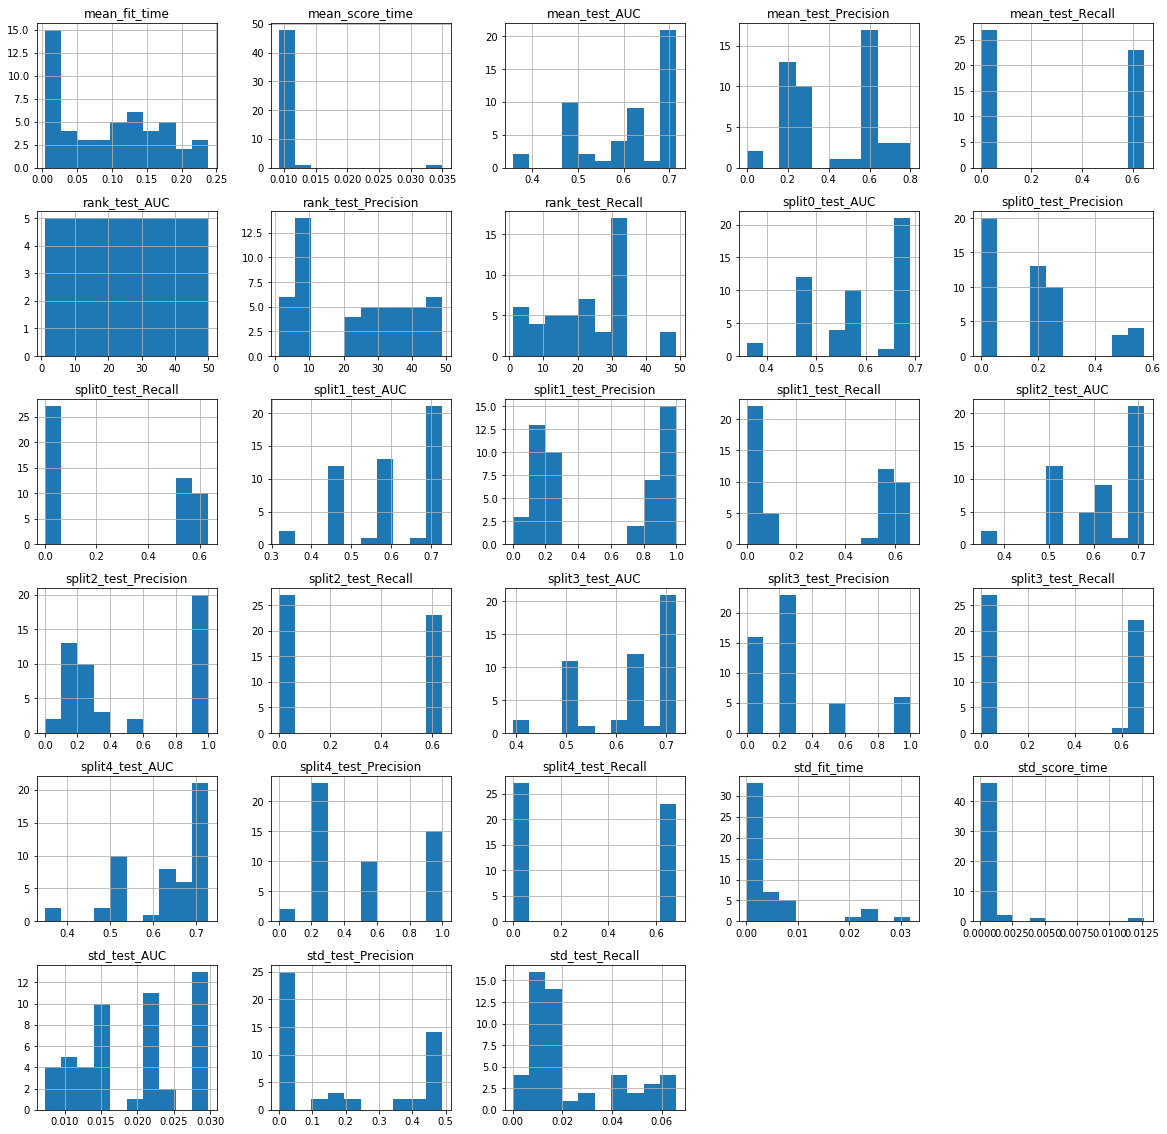

In [67]:
pd.DataFrame(best_random_model.cv_results_).hist(figsize=(20, 20));

### Show Parameters of best model

In [68]:
# show best model parameters
best_random_model.best_params_

{'solver': 'liblinear',
 'penalty': 'l1',
 'max_iter': 117.24800833099896,
 'class_weight': 'balanced',
 'C': 0.5976450846113697}

In [ ]:
# show best models best score
best_random_model.

## Model Evaluation

### Predict on Test Data

In [ ]:
# do prediction on test data using best model
y_pred = 

### Show Confusion  Matrix

In [ ]:
cm = confusion_matrix_plot(y_test, y_pred)

### Model Evaluation - Statistics

In [ ]:
show_scores(cm);

### ROC-AUC Score

In [ ]:
plot_roc_auc_curve(y_test, y_pred, best_random_model, x_test)

A common way to visualize the trade-offs of different thresholds is by using an ROC curve, a plot of the true positive rate (# true positives/ total # positives) versus the false positive rate (# false positives /
total # negatives) for all possible choices of thresholds. A model with good classification accuracy should have significantly more true positives than false positives at all thresholds. 

The optimum position for roc curve is towards the top left corner where the specificity and sensitivity are at optimum levels

The area under the ROC curve quantifies model classification accuracy; the higher the area, the greater the disparity between true and false positives, and the stronger the model in classifying members of the training dataset. An area of 0.5 corresponds to a model that performs no better than random classification and a good classifier stays as far away from that  as possible. An area of 1 is ideal. The closer the AUC to 1 the better.

### Plot Predicted Probability Histograms on Positive and Negative Classes

In [ ]:
# predict on test data for positive and negative classes separately
y_pos_proba = 
y_neg_proba = 

In [ ]:
def hist_pair_plot(a, b, labels=('a', 'b'), bins=20, figsize=(10,10)):
    plt.hist(a, alpha=0.5, label=labels[0], bins=bins)
    plt.hist(b, alpha=0.5, label=labels[1], bins=bins)
    plt.legend(loc='best')
    plt.show()

In [ ]:
hist_pair_plot(y_pos_proba[:, 1], y_neg_proba[:, 1], labels=('Positives', 'Negatives'), bins=30)

### Plot Precision-Recall Curve and find optimal threshold

In [ ]:
y_pred_prob = best_random_model.predict_proba(x_test)[:,1]
pr_rec_df, opt_thresh = precision_recall_f1_curve_plot(y_test, y_pred_prob)

In [ ]:
print(f'Threshold which gives the best F1 score is: {opt_thresh}')

### show confusion matrix again

In [ ]:
cm_ = confusion_matrix_plot(y_test, binarize(y_pred_prob, opt_thresh))

In [ ]:
_,_,_,f1_best = show_scores(cm_)

In [ ]:
print(f'Our best F1 score is: {f1_best}')

## <font color=RoyalBlue>Appendix

http://www.who.int/mediacentre/factsheets/fs317/en/

#### Data Source References

https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset/data

